In [1]:
import numpy as np
import tensorflow as tf
import random
import math
from pathlib import Path
from single_mixed_classes import mixedBrainRegionsRNN
# from mixed_classes_restricted_input import mixedBrainRegionsRNN
from classes import MyBumpBasic

from model_utils import TargetDistractor, get_bump_attractor_weights,create_model_dataset, get_correct_trials#,TargetDistractorMotorPrep
from analysis_utils import get_neuron_selectivity, get_trialwise_mean, split_train_test, find_selective_locations, find_non_selective_locations, zscore_dataset, plot_cross_temporal_decoding, compute_performance_LDA_with_PCAprefit, compute_performance_LDA_with_PCAcomponents 
from matplotlib import pyplot as plt
# plt.style.use('classic')
import itertools
from collections import defaultdict 
from scipy import stats
from itertools import combinations
import sys
import pickle
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Set parameters to load the respective datasets

In [2]:
# # Ranging Parameters
max_iters = 200000
model_version_range = np.arange(1) # number of model versions
monkey_session_data = np.load('saved_results/'+'monkey_session_selectivity_trial_data.npy', allow_pickle=True).item()
# set tau and dt parameter ranges
tau_range =[200] # The intrinsic time constant of neural state decay.
dt_percentage = {200:1/4} # The simulation timestep. Can vary between 1/4 and 1/5 of the tau parameter 

input_sigma_range = [0.01] # Noise applied to the input signal
recurrent_noise_range =[0.08] # Independent recurrent noise for each neuronal cell

# Connection percentages between bump and non-bump regions
inner_connect_percen_range = [0.05]
# Connection percentages between 
inter_connect_percen_range = [0]

# Percentage of connections to the downstream output layer
output_projection_percentage = 0.8

bump_percen_range =[0.075]

# folder to save the model data
data_folder_list = ['datasets']
# 
data_folder = 'datasets'
bump_rec_strength = 1


In [3]:
data_folder

'datasets'

# Load Datasets

In [8]:
dataset = {}
dataset_labels = {}
# dataset_weights = {}

dataset_output ={}
dataset_gt={}
dataset_mask={}

In [9]:
model_accuracies_dlpfc = defaultdict(list)

for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        for bump_percen in bump_percen_range:
            if bump_percen == 0:
                N_rec1 = bump_population
            elif bump_percen == 1:
                N_rec1 = bump_population
            else:
                N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
            for tau in tau_range:
                dt = int(tau*dt_percentage[tau])
                for input_sigma in input_sigma_range:
                    for recurrent_noise in recurrent_noise_range: 
                        for inter_connect_percen in inter_connect_percen_range:
                            for inner_connect_percen in inner_connect_percen_range:
                                params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                print(params_values)
                                for model_version in model_version_range:
                                    for region in ['DLPFC']:
                                        print(region)
                                        for session in np.arange(len(monkey_session_data[region])):
                                            drt = TargetDistractor(N_inputs = inputs, N_outputs=outputs, dt= dt, tau=tau, T=dt*58,
                                                                    cue_start=dt*2, cue_end=dt*8, dis_start=dt*28, dis_end=dt*34, decision_start=dt*54,
                                                                    N_batch = N_batch,
                                                                    sigma=input_sigma)
                                            # name of the model
                                            name1 = name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_' #  Unique name used to determine variable scope for internal use.        
                                            # add the session number in the model name
                                            name = name1+str(model_version)
                                            print("\nIteration: ", model_version, "\nModel name: ", name)

                                            key_name = params_values+name
                                            print(key_name)

                                            dataset[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_trial_data_epoch'+str(epoch)+'.npy')
                                            dataset_labels[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_trial_labels_epoch'+str(epoch)+'.npy')
                                            dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_output_epoch'+str(epoch)+'.npy')
                                            dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_gt_epoch'+str(epoch)+'.npy')
                                            dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_mask_epoch'+str(epoch)+'.npy')

                                            if region == 'DLPFC':
                                                model_accuracies_dlpfc[data_folder+params_values+name1+'_'+region+'_accuracies'].append(drt.accuracy_function(dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)]))


datasets
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
DLPFC

Iteration:  0 
Model name:  bump0.075_480Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_0


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_0_DLPFC0_trial_data_epoch.npy'

In [17]:
accuracies_dlpfc = []
for k in model_accuracies_dlpfc.keys():
    accuracies_dlpfc.append(model_accuracies_dlpfc[k])

full_space = np.arange(len(bump_percen_range))


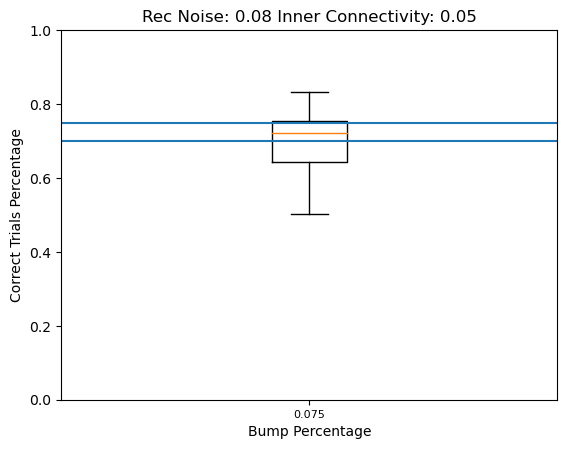

In [18]:
plt.boxplot(accuracies_dlpfc, positions=np.arange(len(bump_percen_range)))
plt.xticks(full_space, bump_percen_range, fontsize=8)
plt.ylim([0, 1])
plt.title("Rec Noise: "+str(recurrent_noise)+" Inner Connectivity: "+str(inner_connect_percen))
plt.xlabel('Bump Percentage')
plt.ylabel('Correct Trials Percentage')
plt.axhline(y=[0.7])
plt.axhline(y=[0.75])
plt.show()

# Correlation analysis

In [261]:
hist_bins = 50
histogram_xrange = [-1, 1]

model_percentages = defaultdict(list)

np.random.seed(10)

all_neurons = defaultdict(list)
all_neurons_labels = defaultdict(list)

significance_level_range = [1e-5]
p_value_threshold = [1e-5]

method = 't-test-locations'

version_pairs_region1 = {}
version_correlations_region1 = {}
version_pvalues_region1 = {}

version_pairs_ = defaultdict(list)
version_correlations_ = defaultdict(list)
version_pvalues_ = defaultdict(list)

model_plot_pairs_bump_low = defaultdict(list)
model_plot_pairs_nonbump_low = defaultdict(list)
model_plot_pairs_corr_mix_low = defaultdict(list)
model_plot_all_high_p_value_pairs = defaultdict(list)

# Subsample Full histogram

exploring-inner-connection-of-datasets
Epoch:  
bump0.075_480Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
DLPFC
bump0.075_480Nrec_ 0
Session:  0
Session trials:  480
Selective Combinations:  17315
Session Selective neuron:  210
Session selectivity:  0.4375
Session contribution:  0.009615384615384616
Session:  1
Session trials:  480
Selective Combinations:  17612
Session Selective neuron:  216
Session selectivity:  0.45
Session contribution:  0.03461538461538462
Session:  2
Session trials:  360
Selective Combinations:  14416
Session Selective neuron:  204
Session selectivity:  0.425
Session contribution:  0.014010989010989012
Session:  3
Session trials:  440
Selective Combinations:  16437
Session Selective neuron:  210
Session selectivity:  0.4375
Session contribution:  0.004807692307692308
Session:  4
Session trials:  440
Selective Combinations:  15677
Session Selective neuron:  207
Session selectivity:  0.43125
Session contribution:  0.0

Selective Combinations:  11054
Session Selective neuron:  185
Session selectivity:  0.3854166666666667
Session contribution:  0.012706043956043958
Session:  22
Session trials:  500
Selective Combinations:  9610
Session Selective neuron:  181
Session selectivity:  0.3770833333333333
Session contribution:  0.016575091575091575
Session:  23
Session trials:  420
Selective Combinations:  8688
Session Selective neuron:  169
Session selectivity:  0.35208333333333336
Session contribution:  0.015476190476190478
Session:  24
Session trials:  420
Selective Combinations:  9254
Session Selective neuron:  173
Session selectivity:  0.36041666666666666
Session contribution:  0.007921245421245423
bump0.075_480Nrec_ 2
Session:  0
Session trials:  480
Selective Combinations:  21150
Session Selective neuron:  229
Session selectivity:  0.47708333333333336
Session contribution:  0.010485347985347986
Session:  1
Session trials:  480
Selective Combinations:  19262
Session Selective neuron:  228
Session select

Session Selective neuron:  133
Session selectivity:  0.27708333333333335
Session contribution:  0.012179487179487181
Session:  23
Session trials:  420
Selective Combinations:  3962
Session Selective neuron:  119
Session selectivity:  0.24791666666666667
Session contribution:  0.010897435897435899
Session:  24
Session trials:  420
Selective Combinations:  4648
Session Selective neuron:  128
Session selectivity:  0.26666666666666666
Session contribution:  0.005860805860805861
bump0.075_480Nrec_ 5
Session:  0
Session trials:  480
Selective Combinations:  10632
Session Selective neuron:  179
Session selectivity:  0.3729166666666667
Session contribution:  0.008195970695970696
Session:  1
Session trials:  480
Selective Combinations:  9655
Session Selective neuron:  167
Session selectivity:  0.34791666666666665
Session contribution:  0.026762820512820515
Session:  2
Session trials:  360
Selective Combinations:  8134
Session Selective neuron:  165
Session selectivity:  0.34375
Session contribu

Selective Combinations:  16057
Session Selective neuron:  204
Session selectivity:  0.425
Session contribution:  0.014010989010989012
Session:  20
Session trials:  320
Selective Combinations:  14687
Session Selective neuron:  208
Session selectivity:  0.43333333333333335
Session contribution:  0.009523809523809525
Session:  21
Session trials:  500
Selective Combinations:  18749
Session Selective neuron:  217
Session selectivity:  0.45208333333333334
Session contribution:  0.014903846153846155
Session:  22
Session trials:  500
Selective Combinations:  18395
Session Selective neuron:  219
Session selectivity:  0.45625
Session contribution:  0.020054945054945057
Session:  23
Session trials:  420
Selective Combinations:  14206
Session Selective neuron:  208
Session selectivity:  0.43333333333333335
Session contribution:  0.01904761904761905
Session:  24
Session trials:  420
Selective Combinations:  14924
Session Selective neuron:  208
Session selectivity:  0.43333333333333335
Session contr

Selective Combinations:  3472
Session Selective neuron:  118
Session selectivity:  0.24583333333333332
Session contribution:  0.008104395604395603
Session:  17
Session trials:  200
Selective Combinations:  3748
Session Selective neuron:  127
Session selectivity:  0.26458333333333334
Session contribution:  0.008722527472527473
Session:  18
Session trials:  520
Selective Combinations:  11663
Session Selective neuron:  197
Session selectivity:  0.41041666666666665
Session contribution:  0.009020146520146521
Session:  19
Session trials:  420
Selective Combinations:  8949
Session Selective neuron:  177
Session selectivity:  0.36875
Session contribution:  0.012156593406593407
Session:  20
Session trials:  320
Selective Combinations:  7361
Session Selective neuron:  164
Session selectivity:  0.3416666666666667
Session contribution:  0.00750915750915751
Session:  21
Session trials:  500
Selective Combinations:  8932
Session Selective neuron:  178
Session selectivity:  0.37083333333333335
Sessi

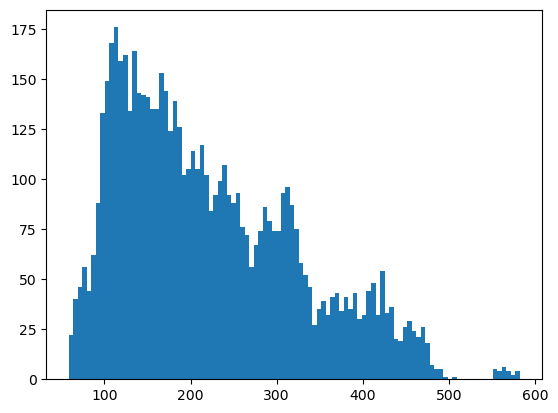

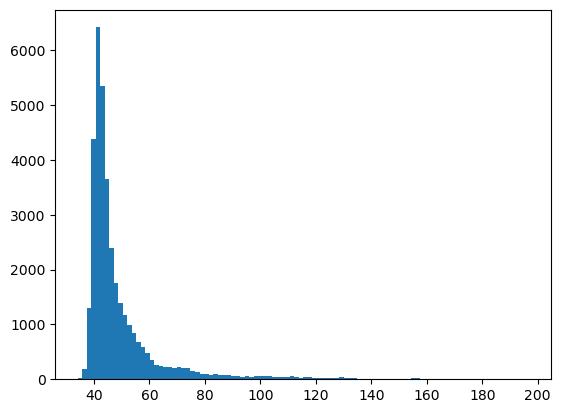

Pairs:  2131541


/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


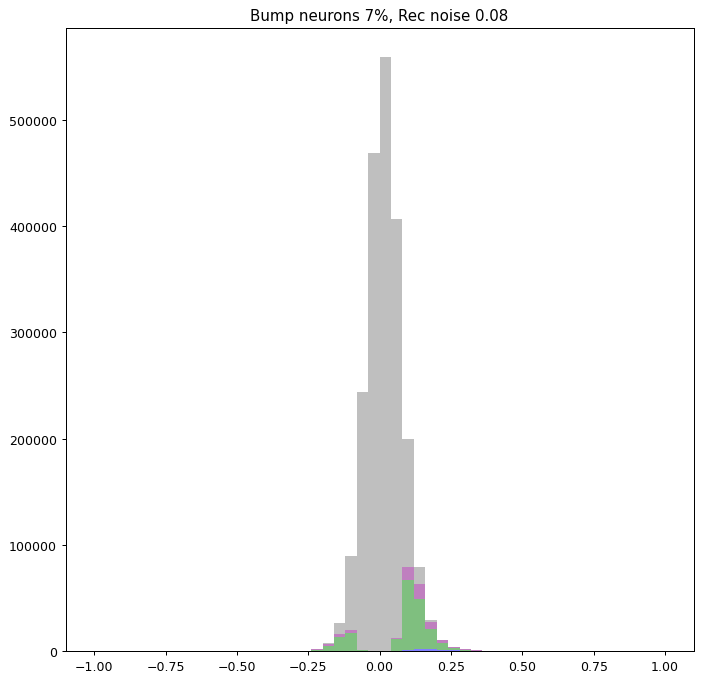

In [20]:
histogram_xrange = [-1,1]
for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
            non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
#             print('Epoch:', epoch)
            model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
            print(model_name)
            for significance_level in significance_level_range:
                for tau in tau_range:
                    dt = int(tau*dt_percentage[tau])
                    time_window = [18, 28]
                    delay1_size = 2*(time_window[1]-time_window[0])
                    for input_sigma in input_sigma_range:
                        for recurrent_noise in recurrent_noise_range: 
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:

                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'

                                    print(params_values)

                                    for region in ['DLPFC']:
                                        print(region)
                                        pairs1 = []
                                        pairs2 = []
                                        pairs3 = []
                                        pair_correlations1 = [] # for bump pair neurons
                                        pair_correlations2 = [] # for non bump pair neurons
                                        pair_correlations3 = [] # for bump-non bump pair neurons
                                        p_values1 = []
                                        p_values2 = []
                                        p_values3 = []

                                        bump_spike_rates=[]
                                        non_bump_spike_rates = []
                                        for model_version in model_version_range:
                                            print(model_name, model_version)
                                            session_contributions = []
                                            for session in np.arange(len(monkey_session_data[region])):
                                                print('Session: ', session)
                                                session_contribution = monkey_session_data[region][session][1]
        #                                         print(session_contribution)
                                                pair_correlations = []
                                                p_values_lists = []
                                                checked_pairs = []
                                                checked_singles = []
                                                checked_singles2 = []

                                                session_selective = []
                                                selective_combinations = []
                                                # Load datasets
                                                data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                axis=1)+1
                                                data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                print("Session trials: ", data.shape[0])
                                                # keep only correct trials
                                                correct_trials = get_correct_trials(data_gt, data_output, data_mask)
                                                data = data[correct_trials,:,:]
                                                data_labels = data_labels[correct_trials]
                                                if np.unique(data_labels).size<=1:
                                                    print("Skip session, correct data labels only for 1 class!")
                                                    continue

                                                stiched_trial_window_size = 2*(time_window[1]-time_window[0])

                                                zscored_data = zscore_dataset(data[:, time_window[1]-delay1_size:time_window[1], :], data_labels)


                                                selective = get_neuron_selectivity(data[:, time_window[0]:time_window[1], :],
                                                                                   data_labels, method=method,
                                                                                   anova_significance_p=significance_level, ttest_significance_p=significance_level,
                                                                                   prestim_dataset=data[:, 0:2, :])
                                                for key_stim in selective.keys():
                                                    # find all the selective neurons combinations to iterate through
                                                    selective_combinations+=list(combinations(selective[key_stim],2))
                                                print('Selective Combinations: ',len(selective_combinations))
                                                if selective_combinations:
                                                    pair_mapping = []
                                                    for pair in selective_combinations:
                                                        if pair not in checked_pairs:# and np.mod(np.abs(pair[0]-pair[1]),79)<2:
                                                            # find the overlapping locations of the pair cells
                                                            overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective)]
                                                            if len(overlaping_locs)!=0:
                                                                # filter locations based on firing rates of the pair neurons
                                                                filtered_locs = defaultdict(list)
                                                                for cell in pair:
                                                                    for lc in overlaping_locs:
                                                                        if cell<bump_population:
                                                                                filtered_locs[cell].append(lc)
                                                                        else:
                                                                                filtered_locs[cell].append(lc)

                                                                common_locs = set(filtered_locs[pair[0]]).intersection(filtered_locs[pair[1]])
                                                                if common_locs:
                                                                    all_trials = np.array([])
                                                                    for all_loc in common_locs:
                                                                        all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                                                    all_trials = all_trials.astype(int) 
                                                                    stiched_zscored_neuron_trials = np.zeros((2, stiched_trial_window_size*all_trials.shape[0]))
                                                                    for n, neuron in enumerate(pair):
                                                                        stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)

                                                                    if bump_percen ==0:
                                                                        pair_mapping.append(2)
                                                                    elif bump_percen ==1:
                                                                        pair_mapping.append(1)
                                                                    else:
                                                                        pair_mapping.append(1 if (pair[0]<bump_population and pair[1]<bump_population) else (2 if (pair[0]>=bump_population and pair[1]>=bump_population) else 3))

                                                                    # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                                                    nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                                                    np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                                                    mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                                                    mask[nan_idxs]=False
                                                                    pcis, p_values = stats.pearsonr(stiched_zscored_neuron_trials[0, mask],stiched_zscored_neuron_trials[1, mask])
                                                                    pair_correlations.append(pcis)
                                                                    p_values_lists.append(p_values)
                                                                    checked_pairs.append(pair)
                                                                    for neuron in pair:
                                                                        if neuron not in checked_singles2:
                                                                            checked_singles2.append(neuron)
                                                                            if session in [1,2] and region == 'DLPFC':
                                                                                all_neurons[data_folder+params_values+model_name+'epoch'+str(epoch)].append(data[all_trials, time_window[1]-delay1_size:time_window[1], neuron])
                                                                                all_neurons_labels[data_folder+params_values+model_name+'epoch'+str(epoch)].append(neuron)

                                                    # keep all pairs and their correlations for each model version to
                                                    # use in temporal decoding based on percentile of correlations histogram
                                                    version_pairs_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = checked_pairs
                                                    version_correlations_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = pair_correlations
                                                    version_pvalues_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = p_values_lists

                                                    # keep only from 1 session and 1 region for each model version
                                                    if session == 0 and region == 'DLPFC': 
#                                                     if region == 'FEF':
                                                        pairs1.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==1)]+(N_rec1*model_version))
                                                        pairs2.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==2)]+(N_rec1*model_version))
                                                        pairs3.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==3)]+(N_rec1*model_version))

                                                        pair_correlations1.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==1)]))
                                                        pair_correlations2.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==2)]))
                                                        pair_correlations3.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==3)]))
                                                        p_values1.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==1)]))
                                                        p_values2.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==2)]))
                                                        p_values3.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==3)]))
                                                # add selectivity contribution for all sessions
                                                selective_neurons = len(np.unique(np.array(checked_pairs)))
                                                session_selectivity = selective_neurons/data.shape[-1]
                                                session_contributions.append( session_selectivity*session_contribution )
                                                print("Session Selective neuron: ",selective_neurons)
                                                print("Session selectivity: ", session_selectivity)
                                                print("Session contribution: ", session_contributions[-1])

                                            model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append( np.sum(session_contributions) )
                                        flatten_pairs1 = np.array([item for sublist in pairs1 for item in sublist])
                                        flatten_pairs2 = np.array([item for sublist in pairs2 for item in sublist])
                                        flatten_pairs3 = np.array([item for sublist in pairs3 for item in sublist])

                                        flatten_pair_correlations1 = np.array([item for sublist in pair_correlations1 for item in sublist])
                                        flatten_pair_correlations2 = np.array([item for sublist in pair_correlations2 for item in sublist])
                                        flatten_pair_correlations3 = np.array([item for sublist in pair_correlations3 for item in sublist])
                                        flatten_p_values1 = np.array([item for sublist in p_values1 for item in sublist])
                                        flatten_p_values2 = np.array([item for sublist in p_values2 for item in sublist])
                                        flatten_p_values3 = np.array([item for sublist in p_values3 for item in sublist])

                                        pair_corr_bump_low = flatten_pair_correlations1[np.where(flatten_p_values1<p_value_threshold)]
                                        pair_corr_bump_high = flatten_pair_correlations1[np.where(flatten_p_values1>=p_value_threshold)]

                                        pair_corr_nonbump_low = flatten_pair_correlations2[np.where(flatten_p_values2<p_value_threshold)]
                                        pair_corr_nonbump_high = flatten_pair_correlations2[np.where(flatten_p_values2>p_value_threshold)]

                                        pair_corr_mix_low = flatten_pair_correlations3[np.where(flatten_p_values3<p_value_threshold)]
                                        pair_corr_mix_high = flatten_pair_correlations3[np.where(flatten_p_values3>p_value_threshold)]                                                       

                                        bump_spike_rates_flat = np.array([item for sublist in bump_spike_rates for item in sublist])
                                        non_bump_spike_rates_flat = np.array([item for sublist in non_bump_spike_rates for item in sublist])

                                        all_high_p_value_pairs = np.concatenate([pair_corr_bump_high, pair_corr_nonbump_high, pair_corr_mix_high])

                                        print("Pairs: ", pair_corr_bump_low.shape[0]+pair_corr_nonbump_low.shape[0]+pair_corr_mix_low.shape[0]+all_high_p_value_pairs.shape[0])

                                        plt.figure(figsize=(9, 9), dpi=90)
                                        yy,__,__ = plt.hist([pair_corr_bump_low, pair_corr_nonbump_low,
                                                            pair_corr_mix_low, all_high_p_value_pairs], color=['blue','green', 'purple', 'grey'], bins=hist_bins, stacked=True, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                                                            label=['Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Non-Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Mixed Pairs, p-value < '+str(p_value_threshold),
                                                                   'p-value > '+str(p_value_threshold)])
                                        plt.title('Bump neurons '+str(float(bump_percen*100))+'%, Rec noise '+str(recurrent_noise))

                                        plt.show()

                                        model_plot_pairs_bump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_bump_low
                                        model_plot_pairs_nonbump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_nonbump_low
                                        model_plot_pairs_corr_mix_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_mix_low
                                        model_plot_all_high_p_value_pairs[data_folder+params_values+model_name+'epoch'+str(epoch)] = all_high_p_value_pairs


Tau:  200
exploring-inner-connection-of-datasets


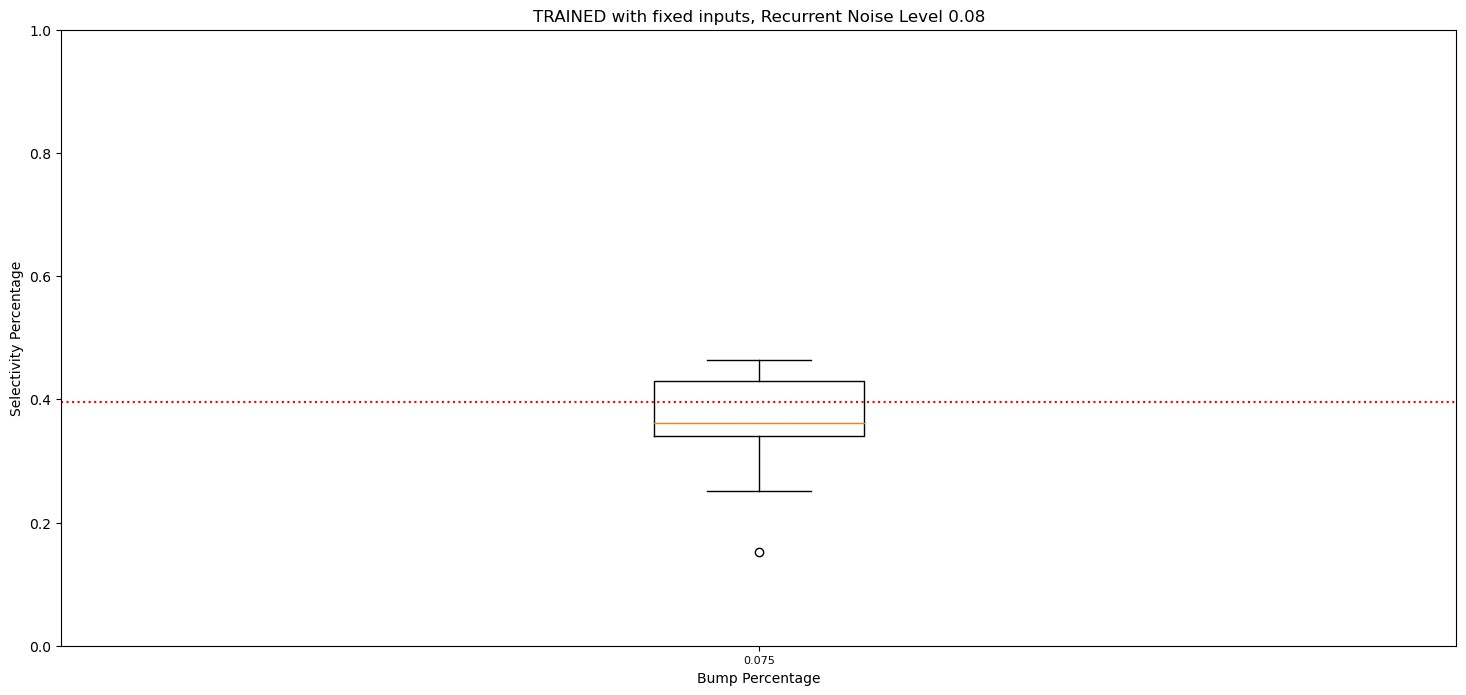

In [28]:
for r, recurrent_noise in enumerate(recurrent_noise_range):
    selective_percentages_dlpfc = []

    x_axis = []
    for tau in tau_range:
        print('Tau: ', tau)
        dt = int(tau*dt_percentage[tau])#int(tau/5)
        for data_folder in data_folder_list:
            print(data_folder)
            for epoch in ['']:
                for bump_percen in bump_percen_range:
                    if bump_percen == 0:
                        N_rec1 = bump_population#120
                    elif bump_percen == 1:
                        N_rec1 = bump_population
                    else:
                        N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                        non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                    model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
        #             print(model_name)
                    for significance_level in significance_level_range:
                        for input_sigma in input_sigma_range:
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    x_axis.append(bump_percen)
                                    selective_percentages_dlpfc.append(model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
#     
    plt.figure(figsize=(18,8))

    full_space = np.arange(len(selective_percentages_fef))

    plt.boxplot(selective_percentages_fef, positions=full_space)
    plt.title('TRAINED with fixed inputs, Recurrent Noise Level '+str(recurrent_noise))

    plt.xticks(full_space, x_axis, fontsize=8)
    plt.ylabel("Selectivity Percentage")
    plt.xlabel("Bump Percentage")

    plt.axhline(y = 36/91, color = 'red', linestyle = 'dotted', label='DLPFC percentage')

#     plt.legend(loc=4, fontsize=4)
    plt.ylim([0,1])
    plt.show()

# Subsample each session

In [313]:
model_significant_neuron_percentages = defaultdict(list)
model_significant_pair_percentages = defaultdict(list)
model_total_significant_non_bump_neuron = defaultdict(list)
model_total_significant_bump_neuron = defaultdict(list)
model_total_non_significant_non_bump_neuron = defaultdict(list)
model_total_non_significant_bump_neuron = defaultdict(list)

model_total_non_selective_neuron = defaultdict(list)
model_total_non_selective_bump_neuron = defaultdict(list)
model_total_non_selective_non_bump_neuron = defaultdict(list)

exploring-inner-connection-of-datasets
Epoch:  
bump0.075_480Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
DLPFC
bump0.075_480Nrec_ 0
Session:  0
Session trials:  480
Selective Combinations:  12
Session Selective neuron:  5
Session selectivity:  0.35714285714285715
Session contribution:  0.007849293563579279
Session:  1
Session trials:  480
Selective Combinations:  35
Session Selective neuron:  7
Session selectivity:  0.5
Session contribution:  0.038461538461538464
Session:  2
Session trials:  360
Selective Combinations:  13
Session Selective neuron:  5
Session selectivity:  0.625
Session contribution:  0.020604395604395604
Session:  3
Session trials:  440
Selective Combinations:  4
Session Selective neuron:  4
Session selectivity:  0.5
Session contribution:  0.005494505494505495
Session:  4
Session trials:  440
Selective Combinations:  4
Session Selective neuron:  4
Session selectivity:  0.5
Session contribution:  0.02197802197802198
Sess

Session:  23
Session trials:  420
Selective Combinations:  7
Session Selective neuron:  5
Session selectivity:  0.7142857142857143
Session contribution:  0.031397174254317116
Session:  24
Session trials:  420
Selective Combinations:  1
Session Selective neuron:  2
Session selectivity:  0.2857142857142857
Session contribution:  0.006279434850863423
bump0.075_480Nrec_ 2
Session:  0
Session trials:  480
Selective Combinations:  11
Session Selective neuron:  7
Session selectivity:  0.5
Session contribution:  0.01098901098901099
Session:  1
Session trials:  480
Selective Combinations:  33
Session Selective neuron:  8
Session selectivity:  0.5714285714285714
Session contribution:  0.04395604395604396
Session:  2
Session trials:  360
Selective Combinations:  2
Session Selective neuron:  3
Session selectivity:  0.375
Session contribution:  0.012362637362637364
Session:  3
Session trials:  440
Selective Combinations:  3
Session Selective neuron:  3
Session selectivity:  0.375
Session contributi

Session:  23
Session trials:  420
Selective Combinations:  5
Session Selective neuron:  3
Session selectivity:  0.42857142857142855
Session contribution:  0.01883830455259027
Session:  24
Session trials:  420
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
bump0.075_480Nrec_ 4
Session:  0
Session trials:  480
Selective Combinations:  34
Session Selective neuron:  8
Session selectivity:  0.5714285714285714
Session contribution:  0.012558869701726845
Session:  1
Session trials:  480
Selective Combinations:  7
Session Selective neuron:  6
Session selectivity:  0.42857142857142855
Session contribution:  0.03296703296703297
Session:  2
Session trials:  360
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  3
Session trials:  440
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  4
Session trials: 

Session:  24
Session trials:  420
Selective Combinations:  3
Session Selective neuron:  3
Session selectivity:  0.42857142857142855
Session contribution:  0.009419152276295134
bump0.075_480Nrec_ 6
Session:  0
Session trials:  480
Selective Combinations:  1
Session Selective neuron:  2
Session selectivity:  0.14285714285714285
Session contribution:  0.0031397174254317113
Session:  1
Session trials:  480
Selective Combinations:  12
Session Selective neuron:  6
Session selectivity:  0.42857142857142855
Session contribution:  0.03296703296703297
Session:  2
Session trials:  360
Selective Combinations:  2
Session Selective neuron:  3
Session selectivity:  0.375
Session contribution:  0.012362637362637364
Session:  3
Session trials:  440
Selective Combinations:  5
Session Selective neuron:  3
Session selectivity:  0.375
Session contribution:  0.004120879120879121
Session:  4
Session trials:  440
Selective Combinations:  1
Session Selective neuron:  2
Session selectivity:  0.25
Session contri

Session:  1
Session trials:  480
Selective Combinations:  4
Session Selective neuron:  5
Session selectivity:  0.35714285714285715
Session contribution:  0.027472527472527476
Session:  2
Session trials:  360
Selective Combinations:  1
Session Selective neuron:  2
Session selectivity:  0.25
Session contribution:  0.008241758241758242
Session:  3
Session trials:  440
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  4
Session trials:  440
Selective Combinations:  5
Session Selective neuron:  4
Session selectivity:  0.5
Session contribution:  0.02197802197802198
Session:  5
Session trials:  540
Selective Combinations:  8
Session Selective neuron:  6
Session selectivity:  0.5
Session contribution:  0.03296703296703297
Session:  6
Session trials:  620
Selective Combinations:  23
Session Selective neuron:  10
Session selectivity:  0.43478260869565216
Session contribution:  0.01433349259436216
Session:  7
Session trials:  62

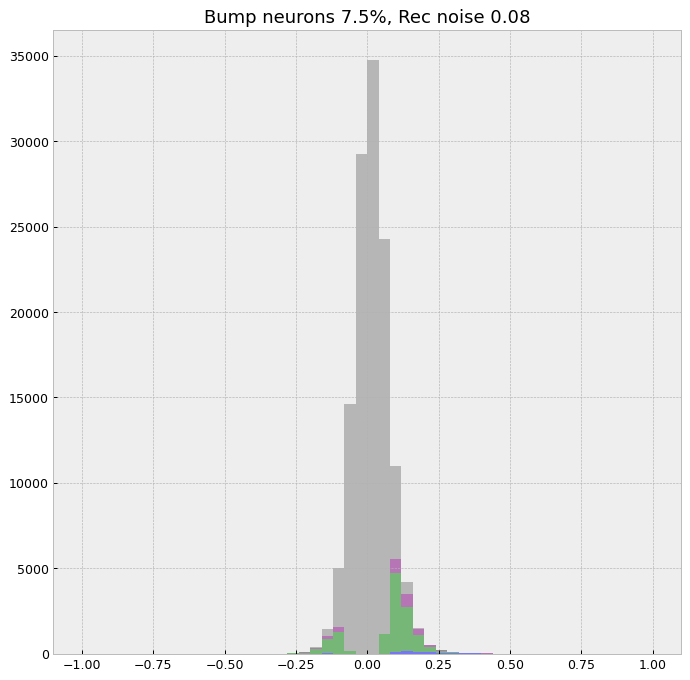

In [314]:
histogram_xrange = [-1,1]
subsampling_iterations = 100
for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
            non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
#             print('Epoch:', epoch)
            model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
            print(model_name)
            for significance_level in significance_level_range:
                for tau in tau_range:
                    dt = int(tau*dt_percentage[tau])
                    time_window = [18, 28]
                    delay1_size = 2*(time_window[1]-time_window[0])
                    for input_sigma in input_sigma_range:
                        for recurrent_noise in recurrent_noise_range: 
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    print(params_values)
                                    for region in ['DLPFC']:
                                        print(region)
                                        pairs1 = []
                                        pairs2 = []
                                        pairs3 = []
                                        pair_correlations1 = [] # for bump pair neurons
                                        pair_correlations2 = [] # for non bump pair neurons
                                        pair_correlations3 = [] # for bump-non bump pair neurons
                                        p_values1 = []
                                        p_values2 = []
                                        p_values3 = []
                                        
                                        bump_spike_rates=[]
                                        non_bump_spike_rates = []
                                        for model_version in model_version_range:
                                            print(model_name, model_version)
                                            session_contributions = []
                                            session_significant_neurons = []
                                            session_number_of_neurons = []

                                            session_significant_pairs = []
                                            session_number_of_pairs = []
                                            total_significant_non_bump_neurons = 0
                                            total_significant_bump_neurons = 0
                                            total_non_significant_non_bump_neurons = 0
                                            total_non_significant_bump_neurons = 0
                                            
                                            total_non_selective_neurons = 0
                                            total_non_selective_bump_neurons = 0
                                            total_non_selective_non_bump_neurons = 0
                                            for session in np.arange(len(monkey_session_data[region])):
                                                print('Session: ', session)
                                                session_contribution = monkey_session_data[region][session][1]
                                                session_neurons = monkey_session_data[region][session][2]
        #                                         print(session_contribution)
                                                for subsampling_iteration in np.arange(subsampling_iterations):
                                                    pair_correlations = []
                                                    p_values_lists = []
                                                    checked_pairs = []
                                                    checked_singles = []
                                                    checked_singles2 = []

                                                    session_selective = []
                                                    selective_combinations = []
                                                    # Load datasets
                                                    data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                    axis=1)+1
                                                    data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    if subsampling_iteration == 0:
                                                        print("Session trials: ", data.shape[0])
                                                    # keep only correct trials
                                                    correct_trials = get_correct_trials(data_gt, data_output, data_mask)

                                                    data = data[correct_trials,:,:]
                                                    # subsample the model neuron population to match the monkey data session
                                                    subsampled_indices = np.random.choice(data.shape[-1], session_neurons, replace=False)
                                                    data = data[:,:,subsampled_indices]
                                                    data_labels = data_labels[correct_trials]
                                                    if np.unique(data_labels).size<=1:
                                                        print("Skipp session, correct data labels only for 1 class!")
                                                        continue

                                                    stiched_trial_window_size = 2*(time_window[1]-time_window[0])


                                                    zscored_data = zscore_dataset(data[:, time_window[1]-delay1_size:time_window[1], :], data_labels)


                                                    selective = get_neuron_selectivity(data[:, time_window[0]:time_window[1], :],
                                                                                       data_labels, method=method,
                                                                                       anova_significance_p=significance_level, ttest_significance_p=significance_level,
                                                                                       prestim_dataset=data[:, 0:2, :])
                                                    for key_stim in selective.keys():
                                                        # find all the selective neurons combinations to iterate through
                                                        selective_combinations+=list(combinations(selective[key_stim],2))
                                                    if subsampling_iteration == 0:
                                                        print('Selective Combinations: ',len(selective_combinations))
                                                    if selective_combinations:
                                                        pair_mapping = []
                                                        for pair in selective_combinations:
                                                            if pair not in checked_pairs:# and np.mod(np.abs(pair[0]-pair[1]),79)<2:
                                                                # find the overlapping locations of the pair cells
                                                                overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective)]
                                                                if len(overlaping_locs)!=0:
                                                                    # filter locations based on firing rates of the pair neurons
                                                                    filtered_locs = defaultdict(list)
                                                                    for cell in pair:
                                                                        spike_rate_per_location = []
                                                                        for lc in overlaping_locs:
                                                                            if cell<bump_population:
                                                                                    filtered_locs[cell].append(lc)
                                                                            else:
                                                                                    filtered_locs[cell].append(lc)

                                                                    common_locs = set(filtered_locs[pair[0]]).intersection(filtered_locs[pair[1]])
                                                                    if common_locs:
                                                                        all_trials = np.array([])
                                                                        for all_loc in common_locs:
                                                                            all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                                                        all_trials = all_trials.astype(int) 
                                                                        stiched_zscored_neuron_trials = np.zeros((2, stiched_trial_window_size*all_trials.shape[0]))
                                                                        for n, neuron in enumerate(pair):
                                                                            stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)

                                                                        if bump_percen ==0:
                                                                            pair_mapping.append(2)
                                                                        elif bump_percen ==1:
                                                                            pair_mapping.append(1)
                                                                        else:
#                                                                             pair_mapping.append(1 if (pair[0]<bump_population and pair[1]<bump_population) else (2 if (pair[0]>=bump_population and pair[1]>=bump_population) else 3))
                                                                            pair_mapping.append(1 if (subsampled_indices[pair[0]]<bump_population and subsampled_indices[pair[1]]<bump_population) else (2 if (subsampled_indices[pair[0]]>=bump_population and subsampled_indices[pair[1]]>=bump_population) else 3))

                                                                        # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                                                        nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                                                        np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                                                        mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                                                        mask[nan_idxs]=False
                                                                        pcis, p_values = stats.pearsonr(stiched_zscored_neuron_trials[0, mask],stiched_zscored_neuron_trials[1, mask])
                                                                        pair_correlations.append(pcis)
                                                                        p_values_lists.append(p_values)
                                                                        checked_pairs.append(pair)

                                                        # keep all pairs and their correlations for each model version to
                                                        # use in temporal decoding based on percentile of correlations histogram
                                                        version_pairs_[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)].append(checked_pairs)
                                                        version_correlations_[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)].append(pair_correlations)
                                                        version_pvalues_[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)].append(p_values_lists)

                                                        # keep only from 1 session and 1 region for each model version
                                                        if region == 'DLPFC':
                                                            pairs1.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==1)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))#(N_rec1*model_version))
                                                            pairs2.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==2)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))
                                                            pairs3.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==3)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))

                                                            pair_correlations1.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==1)]))
                                                            pair_correlations2.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==2)]))
                                                            pair_correlations3.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==3)]))
                                                            p_values1.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==1)]))
                                                            p_values2.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==2)]))
                                                            p_values3.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==3)]))

                                                    # calculate significant neurons and pairs
                                                    significant_pairs = np.array(checked_pairs)[np.where(np.array(p_values_lists)<significance_level)[0]]
                                                    non_significant_pairs = np.array(checked_pairs)[np.where(np.array(p_values_lists)>=significance_level)[0]]

                                                    significant_neurons = np.unique(significant_pairs)
                                                    non_significant_neurons = np.unique(non_significant_pairs)

                                                    significant_neurons_number =  len(significant_neurons)
                                                    non_significant_neurons_number = len(non_significant_neurons)
                                                    
                                                    significant_pairs_number = len(significant_pairs)
                                                    non_significant_pairs_number = len(non_significant_pairs)
                                                    
                                                    original_neuron_indices_significant = np.array([subsampled_indices[n_] for n_ in significant_neurons])
                                                    total_significant_non_bump_neurons += np.where(original_neuron_indices_significant>=bump_population)[0].shape[0]
                                                    total_significant_bump_neurons += np.where(original_neuron_indices_significant<bump_population)[0].shape[0]
                                                    
                                                    original_neuron_indices_non_significant = np.array([subsampled_indices[n_] for n_ in non_significant_neurons if subsampled_indices[n_] not in original_neuron_indices_significant])
                                                    total_non_significant_non_bump_neurons += np.where(original_neuron_indices_non_significant>=bump_population)[0].shape[0]
                                                    total_non_significant_bump_neurons += np.where(original_neuron_indices_non_significant<bump_population)[0].shape[0]
                                                    
                                                    # check non selective neurons
                                                    total_non_selective_neurons += subsampled_indices.shape[0]- np.unique(checked_pairs).shape[0]
                                                    
                                                    original_neuron_indices_selective = np.array([subsampled_indices[n_] for n_ in np.unique(checked_pairs)])
                                                    original_neuron_indices_non_selective = np.array([neuron_ for neuron_ in subsampled_indices if neuron_ not in original_neuron_indices_selective])
                                                    total_non_selective_bump_neurons += np.where(original_neuron_indices_non_selective<bump_population)[0].shape[0]
                                                    total_non_selective_non_bump_neurons += np.where(original_neuron_indices_non_selective>=bump_population)[0].shape[0]
                                                    
                                                    session_significant_neurons.append(significant_neurons_number)
                                                    session_number_of_neurons.append(len(np.unique(checked_pairs)))
                                                    session_significant_pairs.append(significant_pairs_number)
                                                    session_number_of_pairs.append(len(checked_pairs))
                                                    
                                                    if subsampling_iteration == 0:
                                                        # add selectivity contribution for all sessions
                                                        selective_neurons = len(np.unique(np.array(checked_pairs)))
                                                        session_selectivity = selective_neurons/data.shape[-1]
                                                        session_contributions.append( session_selectivity*session_contribution )
                                                        print("Session Selective neuron: ",selective_neurons)
                                                        print("Session selectivity: ", session_selectivity)
                                                        print("Session contribution: ", session_contributions[-1])
                                                
                                            model_significant_neuron_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append(np.sum(session_significant_neurons)/np.sum(session_number_of_neurons))
                                            model_significant_pair_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append(np.sum(session_significant_pairs)/np.sum(session_number_of_pairs))
                                            model_total_significant_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_significant_non_bump_neurons)
                                            model_total_significant_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_significant_bump_neurons)
                                            model_total_non_significant_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_significant_non_bump_neurons)
                                            model_total_non_significant_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_significant_bump_neurons)
                                            
                                            model_total_non_selective_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_selective_neurons)
                                            model_total_non_selective_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_selective_bump_neurons)
                                            model_total_non_selective_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_selective_non_bump_neurons)

                                        flatten_pairs1 = np.array([item for sublist in pairs1 for item in sublist])
                                        flatten_pairs2 = np.array([item for sublist in pairs2 for item in sublist])
                                        flatten_pairs3 = np.array([item for sublist in pairs3 for item in sublist])

                                        flatten_pair_correlations1 = np.array([item for sublist in pair_correlations1 for item in sublist])
                                        flatten_pair_correlations2 = np.array([item for sublist in pair_correlations2 for item in sublist])
                                        flatten_pair_correlations3 = np.array([item for sublist in pair_correlations3 for item in sublist])
                                        flatten_p_values1 = np.array([item for sublist in p_values1 for item in sublist])
                                        flatten_p_values2 = np.array([item for sublist in p_values2 for item in sublist])
                                        flatten_p_values3 = np.array([item for sublist in p_values3 for item in sublist])

                                        pair_corr_bump_low = flatten_pair_correlations1[np.where(flatten_p_values1<p_value_threshold)]
                                        pair_corr_bump_high = flatten_pair_correlations1[np.where(flatten_p_values1>=p_value_threshold)]

                                        pair_corr_nonbump_low = flatten_pair_correlations2[np.where(flatten_p_values2<p_value_threshold)]
                                        pair_corr_nonbump_high = flatten_pair_correlations2[np.where(flatten_p_values2>p_value_threshold)]

                                        pair_corr_mix_low = flatten_pair_correlations3[np.where(flatten_p_values3<p_value_threshold)]
                                        pair_corr_mix_high = flatten_pair_correlations3[np.where(flatten_p_values3>p_value_threshold)]                                                       

                                        bump_spike_rates_flat = np.array([item for sublist in bump_spike_rates for item in sublist])
                                        non_bump_spike_rates_flat = np.array([item for sublist in non_bump_spike_rates for item in sublist])

                                        all_high_p_value_pairs = np.concatenate([pair_corr_bump_high, pair_corr_nonbump_high, pair_corr_mix_high])

                                        print("Pairs: ", pair_corr_bump_low.shape[0]+pair_corr_nonbump_low.shape[0]+pair_corr_mix_low.shape[0]+all_high_p_value_pairs.shape[0])

                                        plt.figure(figsize=(9, 9), dpi=90)
                                        yy,__,__ = plt.hist([pair_corr_bump_low, pair_corr_nonbump_low,
                                                            pair_corr_mix_low, all_high_p_value_pairs], color=['blue','green', 'purple', 'grey'], bins=hist_bins, stacked=True, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                                                            label=['Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Non-Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Mixed Pairs, p-value < '+str(p_value_threshold),
                                                                   'p-value > '+str(p_value_threshold)])
                                        plt.title('Bump neurons '+str(float(bump_percen*100))+'%, Rec noise '+str(recurrent_noise))

#                                         plt.legend(loc=2, fontsize=9)
                                        plt.show()

                                        model_plot_pairs_bump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_bump_low
                                        model_plot_pairs_nonbump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_nonbump_low
                                        model_plot_pairs_corr_mix_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_mix_low
                                        model_plot_all_high_p_value_pairs[data_folder+params_values+model_name+'epoch'+str(epoch)] = all_high_p_value_pairs



In [378]:
print("Significant bump pairs", pair_corr_bump_low.shape[0])
print("Significant non-bump pairs", pair_corr_nonbump_low.shape[0])

print("Non Significant bump pairs", pair_corr_bump_high.shape[0])
print("Non Significant non-bump pairs", pair_corr_nonbump_high.shape[0])


Significant bump pairs 559
Significant non-bump pairs 12463
Non Significant bump pairs 810
Non Significant non-bump pairs 88564


# Check bump non-bump correlation significance

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


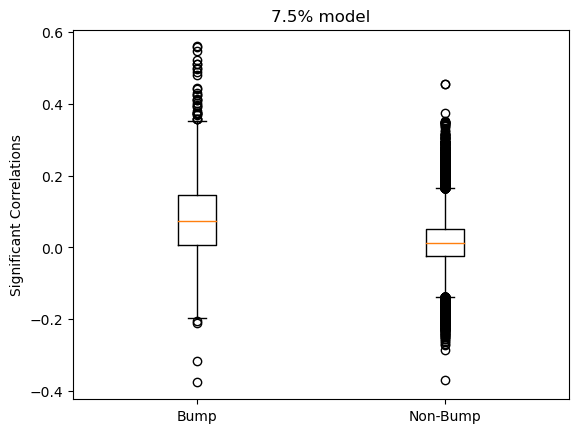

In [427]:
plt.boxplot([flatten_pair_correlations1,flatten_pair_correlations2])
plt.title('7.5% model')
plt.ylabel('Significant Correlations')
plt.xticks(np.arange(2)+1, ['Bump', 'Non-Bump'], fontsize=10)
plt.show()

In [408]:
stats.ttest_ind(flatten_pair_correlations1,
                flatten_pair_correlations2,
                trim=0.49, equal_var=False)

Ttest_indResult(statistic=20.23957448111584, pvalue=2.3039732498405524e-18)

# Signficant Neuron and Pair percentages boxplots

exploring-inner-connection-of-datasets


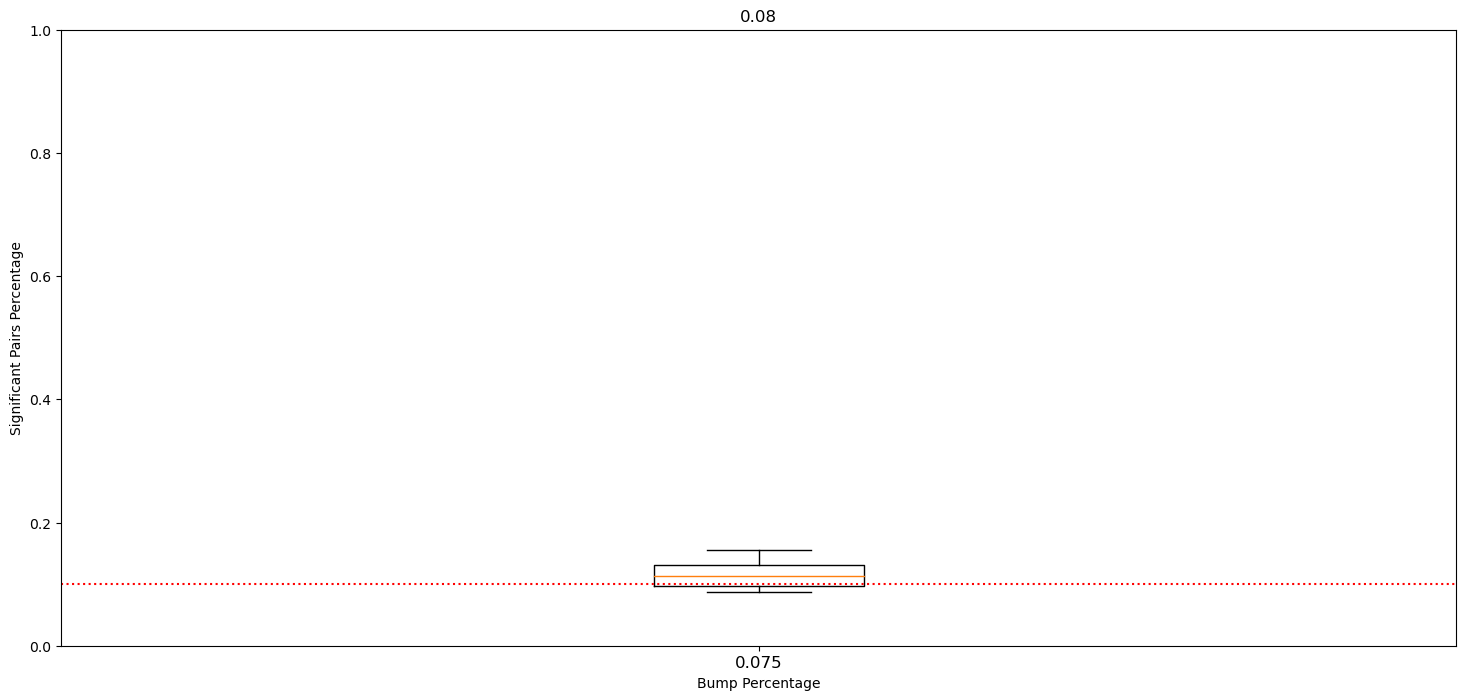

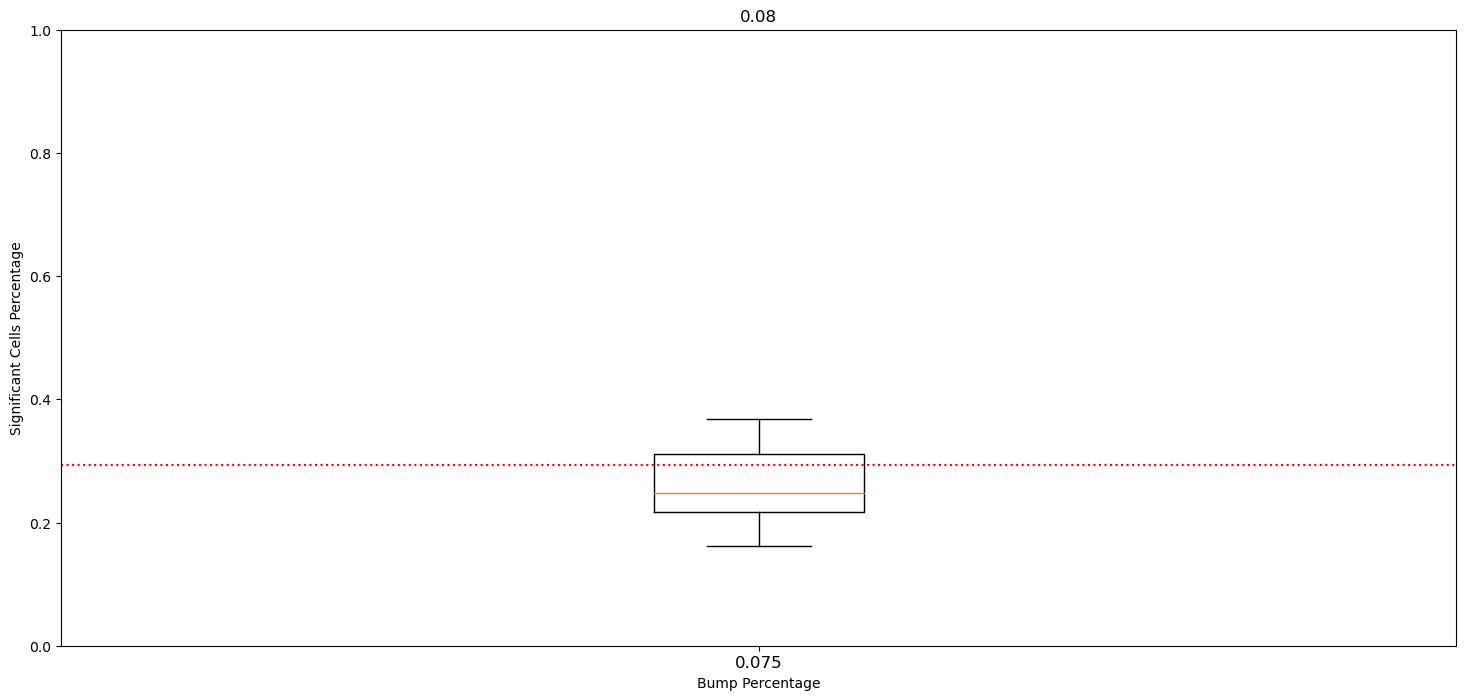

In [26]:
for r, recurrent_noise in enumerate(recurrent_noise_range):
    pair_percentages = defaultdict(list)
    correlations_means = defaultdict(list)
    cell_percentages = defaultdict(list)
    x_axis = []
    for data_folder in data_folder_list:
        print(data_folder)
        for epoch in ['']:
#             print('Epoch: ', epoch)
            for bump_percen in bump_percen_range:
                if bump_percen == 0:
                    N_rec1 = bump_population
                elif bump_percen == 1:
                    N_rec1 = bump_population
                else:
                    N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                    non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
        #         print(model_name)
                for significance_level in significance_level_range:
                    for tau in tau_range:
                        dt = int(tau*dt_percentage[tau])
                        for input_sigma in input_sigma_range:
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    x_axis.append(bump_percen)
                                    pair_percentages[bump_percen].append(model_significant_pair_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
                                    cell_percentages[bump_percen].append(model_significant_neuron_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
    
    plt.figure(figsize=(18,8))
    for b,bump_percent_key in enumerate(pair_percentages.keys()):
            x_space = np.arange(len(pair_percentages[bump_percent_key]))+b*len(pair_percentages[bump_percent_key])
            plt.boxplot(pair_percentages[bump_percent_key], positions=x_space)

    full_space = np.arange(len(pair_percentages[bump_percent_key])*(b+1))
    plt.xticks(full_space, x_axis, fontsize=12)
    plt.ylim([0,1])
    plt.xlabel("Bump Percentage")
    plt.ylabel("Significant Pairs Percentage")
    plt.margins(0.01)

    plt.axhline(y = 3/30, color = 'red', linestyle = 'dotted', label='DLPFC percentage')

    plt.title(str(recurrent_noise))
    plt.show()

    plt.figure(figsize=(18,8))
    for b,bump_percent_key in enumerate(cell_percentages.keys()):
            x_space = np.arange(len(cell_percentages[bump_percent_key]))+b*len(cell_percentages[bump_percent_key])
            plt.boxplot(cell_percentages[bump_percent_key], positions=x_space)

    full_space = np.arange(len(cell_percentages[bump_percent_key])*(b+1))
    plt.xticks(full_space, x_axis, fontsize=12)
    plt.ylim([0,1])
    plt.xlabel("Bump Percentage")
    plt.ylabel("Significant Cells Percentage")
    plt.margins(0.01)
    plt.title(str(recurrent_noise))

    plt.axhline(y = 5/17, color = 'red', linestyle = 'dotted', label='DLPFC percentage')
    plt.show()

# Create Pseudo Populations for Model data

In [124]:
model_datasets = defaultdict(dict)
model_datasets_labels = defaultdict(dict)
monkey_session_data = np.load('saved_results/'+'monkey_session_selectivity_trial_data.npy', allow_pickle=True).item()


In [125]:
for epoch in ['']:
    for bump_percen in bump_percen_range:
                    N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                    non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                    print('Epoch:', epoch)
                    model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
                    print(model_name)
                    for tau in tau_range:
                        dt = int(tau*dt_percentage[tau])
                        for input_sigma in input_sigma_range:
                            for recurrent_noise in recurrent_noise_range:
                                for inter_connect_percen in inter_connect_percen_range:
                                    for inner_connect_percen in inner_connect_percen_range:
                                        params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                        print(params_values)
                                        for region in ['DLPFC']:
                                            model_data_dict = defaultdict(dict)
                                            combined_session_index = 0
                                            for model_version in model_version_range:
                                                print("Model version: ", model_version)
                                                for session in np.arange(len(monkey_session_data[region])):
                                                    print("Session: ", session)
                                                    # Load datasets
                                                    data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                    axis=1)+1
                                                    data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
        #                                             # keep only correct trials
                                                    correct_trials = get_correct_trials(data_gt, data_output, data_mask)
                                                    data = data[correct_trials,:,:]
                                                    data_labels = data_labels[correct_trials]
                                                    print(data.shape)
                                                    print(data_labels.shape)
                                                    combined_session_index+=1
                                                    print("COMBINED SESSION:", combined_session_index)
                                                    significant_neurons_region1 = []
                                                    non_significant_neurons_region1 = []
                                                    significant_neurons_region2 = []
                                                    non_significant_neurons_region2 = []
                                                    
                                                    neuron_pvalues_region1 = defaultdict(list)
                                                    
                                                    #region1
                                                    # create a list for each selective neuron in the session with the p-values of
                                                    # the pairs it takes part in
                                                    if data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch) in version_pairs_region1:
                                                        for j, pair in enumerate(version_pairs_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]):
                                                            # keep only positively significant pairs 
                                                            if version_correlations_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)][j] > 0:
                                                                for neuron in pair:
                                                                    neuron_pvalues_region1[neuron].append(version_pvalues_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)][j])
#                                                                 print(neuron_pvalues, '\n')
                                                        # keep the neurons with high pvalues as non-significnt 
                                                        for k in neuron_pvalues_region1.keys():
                                                            if np.min(neuron_pvalues_region1[k])>=significance_level:
                                                                non_significant_neurons_region1.append(k)
                                                            else:
                                                                significant_neurons_region1.append(k)
    
                                                        print('Significant : ', len(significant_neurons_region1))
                                                        print('Non-Significant : ',len(non_significant_neurons_region1))
                                                    else:
                                                        print("Skipped key: ", params_values+model_name+str(model_version)+'_epoch'+str(epoch))
    
                                                    model_data_dict['significant']['session'+str(combined_session_index)] = data[:,:,significant_neurons_region1]
                                                    model_data_dict['non_significant']['session'+str(combined_session_index)] = data[:,:,non_significant_neurons_region1]

                                                    model_datasets_labels[params_values+model_name]['session'+str(combined_session_index)] = data_labels
                                            model_datasets['epoch'+str(epoch)][params_values+model_name]= model_data_dict.copy()


Epoch: 
bump0.075_480Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
Model version:  0
Session:  0
(362, 58, 480)
(362,)
COMBINED SESSION: 1
Significant :  206
Non-Significant :  4
Session:  1
(371, 58, 480)
(371,)
COMBINED SESSION: 2
Significant :  208
Non-Significant :  8
Session:  2
(277, 58, 480)
(277,)
COMBINED SESSION: 3
Significant :  199
Non-Significant :  5
Session:  3
(353, 58, 480)
(353,)
COMBINED SESSION: 4
Significant :  207
Non-Significant :  3
Session:  4
(341, 58, 480)
(341,)
COMBINED SESSION: 5
Significant :  200
Non-Significant :  7
Session:  5
(412, 58, 480)
(412,)
COMBINED SESSION: 6
Significant :  221
Non-Significant :  2
Session:  6
(470, 58, 480)
(470,)
COMBINED SESSION: 7
Significant :  222
Non-Significant :  5
Session:  7
(469, 58, 480)
(469,)
COMBINED SESSION: 8
Significant :  221
Non-Significant :  4
Session:  8
(197, 58, 480)
(197,)
COMBINED SESSION: 9
Significant :  156
Non-Significant :  11
Session:  9
(186, 58,

Significant :  121
Non-Significant :  16
Session:  10
(305, 58, 480)
(305,)
COMBINED SESSION: 86
Significant :  161
Non-Significant :  8
Session:  11
(310, 58, 480)
(310,)
COMBINED SESSION: 87
Significant :  162
Non-Significant :  7
Session:  12
(231, 58, 480)
(231,)
COMBINED SESSION: 88
Significant :  138
Non-Significant :  17
Session:  13
(229, 58, 480)
(229,)
COMBINED SESSION: 89
Significant :  142
Non-Significant :  8
Session:  14
(162, 58, 480)
(162,)
COMBINED SESSION: 90
Significant :  110
Non-Significant :  21
Session:  15
(149, 58, 480)
(149,)
COMBINED SESSION: 91
Significant :  112
Non-Significant :  14
Session:  16
(126, 58, 480)
(126,)
COMBINED SESSION: 92
Significant :  98
Non-Significant :  15
Session:  17
(129, 58, 480)
(129,)
COMBINED SESSION: 93
Significant :  96
Non-Significant :  21
Session:  18
(344, 58, 480)
(344,)
COMBINED SESSION: 94
Significant :  166
Non-Significant :  4
Session:  19
(258, 58, 480)
(258,)
COMBINED SESSION: 95
Significant :  162
Non-Significant :

(332, 58, 480)
(332,)
COMBINED SESSION: 170
Significant :  199
Non-Significant :  5
Session:  20
(239, 58, 480)
(239,)
COMBINED SESSION: 171
Significant :  201
Non-Significant :  7
Session:  21
(361, 58, 480)
(361,)
COMBINED SESSION: 172
Significant :  212
Non-Significant :  5
Session:  22
(363, 58, 480)
(363,)
COMBINED SESSION: 173
Significant :  212
Non-Significant :  7
Session:  23
(303, 58, 480)
(303,)
COMBINED SESSION: 174
Significant :  199
Non-Significant :  9
Session:  24
(318, 58, 480)
(318,)
COMBINED SESSION: 175
Significant :  204
Non-Significant :  4
Model version:  7
Session:  0
(257, 58, 480)
(257,)
COMBINED SESSION: 176
Significant :  57
Non-Significant :  23
Session:  1
(252, 58, 480)
(252,)
COMBINED SESSION: 177
Significant :  67
Non-Significant :  13
Session:  2
(200, 58, 480)
(200,)
COMBINED SESSION: 178
Significant :  53
Non-Significant :  12
Session:  3
(227, 58, 480)
(227,)
COMBINED SESSION: 179
Significant :  57
Non-Significant :  14
Session:  4
(235, 58, 480)
(2

In [129]:
model_pseudo_populations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

model_pseudo_populations_labels = []
labels = np.arange(1,5)
trials_per_label=100
# set the pseudo pop labels
for label in labels:
        model_pseudo_populations_labels.append(np.ones(trials_per_label)*label)
model_pseudo_populations_labels = np.concatenate(model_pseudo_populations_labels)

for epoch in model_datasets.keys():
    for model_key in model_datasets[epoch].keys():
        for neuron_type in model_datasets[epoch][model_key].keys():            
            for session in model_datasets[epoch][model_key][neuron_type].keys():
                print (model_key, neuron_type, session, model_datasets[epoch][model_key][neuron_type][session].shape)
                for n in np.arange(model_datasets[epoch][model_key][neuron_type][session].shape[-1]):
                    single_neuron_trials = []
                    if np.unique(model_datasets_labels[model_key][session]).size==labels.size:
                        for label in labels:
                            selected_trials = np.random.choice(np.where(model_datasets_labels[model_key][session]==label)[0],
                                                               trials_per_label,
                                                               replace=True)
                            model_neuron_data = model_datasets[epoch][model_key][neuron_type][session][selected_trials,:,n]
                            single_neuron_trials.append(model_neuron_data.reshape(model_neuron_data.shape[0], model_neuron_data.shape[1], 1))

                        model_pseudo_populations[epoch][neuron_type][model_key].append(np.concatenate(single_neuron_trials, axis=0))
                    else:
                        print("Skipped session", session)
            model_pseudo_populations[epoch][neuron_type][model_key] = np.concatenate(model_pseudo_populations[epoch][neuron_type][model_key], axis=2)

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session1 (362, 58, 206)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session2 (371, 58, 208)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session3 (277, 58, 199)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session4 (353, 58, 207)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session5 (341, 58, 200)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session6 (412, 58, 221)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session7 (470, 58, 222)
/stimulus4/dt

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session63 (290, 58, 218)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session64 (271, 58, 224)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session65 (200, 58, 198)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session66 (192, 58, 193)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session67 (163, 58, 182)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session68 (147, 58, 168)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session69 (412, 58, 232)
/stimu

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session123 (337, 58, 116)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session124 (278, 58, 106)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session125 (281, 58, 118)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session126 (370, 58, 171)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session127 (371, 58, 156)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session128 (271, 58, 152)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session129 (336, 58, 160)

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session187 (256, 58, 70)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session188 (187, 58, 45)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session189 (197, 58, 60)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session190 (122, 58, 24)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session191 (138, 58, 28)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session192 (103, 58, 17)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session193 (104, 58, 21)
/stimu

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session248 (362, 58, 231)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session249 (302, 58, 216)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ significant session250 (316, 58, 224)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session1 (362, 58, 4)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session2 (371, 58, 8)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session3 (277, 58, 5)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session4 (353, 58, 3)

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session84 (140, 58, 10)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session85 (146, 58, 16)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session86 (305, 58, 8)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session87 (310, 58, 7)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session88 (231, 58, 17)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session89 (229, 58, 8)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session90 (1

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session182 (335, 58, 13)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session183 (333, 58, 14)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session184 (134, 58, 9)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session185 (126, 58, 14)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session186 (254, 58, 19)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant session187 (256, 58, 17)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ non_significant sess

In [130]:
balancing_pop={}
for epoch in model_pseudo_populations.keys():
    for n_type in model_pseudo_populations[epoch].keys():
        for model_key in model_pseudo_populations[epoch][n_type].keys():
            print(n_type)
            print(model_key)
            print(model_pseudo_populations[epoch][n_type][model_key].shape)
            non_significant_model_neurons = model_pseudo_populations[epoch][n_type][model_key].shape[-1]
            if n_type == 'non_significant':
                balancing_pop[model_key+n_type+epoch] = non_significant_model_neurons
    #         if n_type == '_all':
            elif 'all' in n_type:
                balancing_pop[model_key+n_type+epoch] = non_significant_model_neurons
            elif 'significant' in n_type:
                balancing_pop[model_key+n_type+epoch] = non_significant_model_neurons

significant
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_
(400, 58, 39722)
non_significant
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_
(400, 58, 2517)


In [131]:
model_pseudo_populations['epoch']['significant'].keys()

dict_keys(['/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_'])

In [132]:
model_pseudo_populations['epoch'].keys()

dict_keys(['significant', 'non_significant'])

# Decoding Mixed Model

In [6]:
# init decoding matrix
model_decoding_matrices = defaultdict(list)
model_decoding_matrices_lda = defaultdict(list)
model_decoding_matrices_pca = defaultdict(list)

np.random.seed(10)
decoding_step = 2

decoding_matrix_length = data.shape[1]
time_points = [int(100/dt),
               int(400/dt),
               int(1400/dt),
               int(1700/dt),
               int(2700/dt)]#[2, 8, 28, 34, 54]
T_range = np.arange(0, decoding_matrix_length)


In [7]:
# load decoding matrices
with open('saved_results/'+'0.075_model_cross_temporal_decoding-DLPFC-models-PCA-stiched-delays-1000-balanced-36.pkl', 'rb') as f:
    model_decoding_matrices_lda = pickle.load(f)
time_points = [2, 8, 28, 34, 54]
np.random.seed(100)
decoding_step = 2

In [8]:
time_points

[2, 8, 28, 34, 54]

# Run the cross temporal decoding

In [ ]:
shuffles = 5
balanced_populations= 200

for epoch in model_pseudo_populations.keys():
    print('Epoch: ', epoch)
    for model_pseudo_population in ['significant', 'non_significant']:#model_pseudo_populations[epoch].keys():
        for model_key in model_pseudo_populations[epoch][model_pseudo_population].keys():
            decoding_matrix_length = model_pseudo_populations[epoch][model_pseudo_population][model_key].shape[1]
            rec_noise = model_key.split('/')[-4]
            for balanced_population in np.arange(balanced_populations):
                model_ = model_key.split('/')[-1]+model_pseudo_population+model_key.split('/')[-6]+'_'+rec_noise#+'_'+epoch

                print(model_)
                # balance the populations relative to each case
#                 matched_neurons = np.random.choice(model_pseudo_populations[epoch][model_pseudo_population][model_key].shape[-1],
#                                                    balancing_pop[model_key+'non_significant'+epoch], replace=False)
                matched_neurons = np.random.choice(model_pseudo_populations[epoch][model_pseudo_population][model_key].shape[-1],
#                                                    5, replace=False)
                                                   36)#, replace=False)

                model_data = model_pseudo_populations[epoch][model_pseudo_population][model_key][:,:,matched_neurons]
                print(model_data.shape)
            
                # fit the pca on the whole dataset during second part of delays and then use it during decoding
                concat_data = np.concatenate([model_data[:,18:28,:],
                                              model_data[:,44:54,:]], axis=1)
                pca = PCA(0.9)
                # either fit the mean of the second part of both delays
                pca.fit(np.mean(concat_data,axis=1))
                # or use all the timebins as features to the PCA
#                 features = concat_data.shape[-1] # number of neurons
#                 pca.fit(concat_data.reshape(-1, features))
            
                for shuffle in np.arange(shuffles):
                    print(model_pseudo_population, model_key, balanced_population, shuffle)

                    # cross temporal decoding
                    model_decoding_matrix_lda = np.zeros((int(decoding_matrix_length), int(decoding_matrix_length)))
                    split_dataset = split_train_test(model_data, model_pseudo_populations_labels)

                    for ii, i in enumerate(T_range):
                        train_set = np.mean(split_dataset['train'][:,i:i+decoding_step,:], axis=1)
                        for jj, j in enumerate(T_range):
                            test_set = np.mean(split_dataset['test'][:,j:j+decoding_step,:], axis=1)
                            
#                             model_decoding_matrix_lda[ii,jj] = compute_performance_LDA_with_PCAcomponents(train_set, split_dataset['train_labels'],
#                                                               test_set, split_dataset['test_labels']) 
                            model_decoding_matrix_lda[ii,jj] = compute_performance_LDA_with_PCAprefit(train_set, split_dataset['train_labels'],
                                                              test_set, split_dataset['test_labels'], pca) 
                    # collect decoding matrices for all regions and datasets
                    model_decoding_matrices_lda[model_].append(model_decoding_matrix_lda)
            # plot decoding results
            title = model_
            plot_cross_temporal_decoding(np.mean(model_decoding_matrices_lda[model_], axis=0), title+' LDA',
                                         xylines=time_points,
                                         min_val=0.25, max_val=np.max(np.mean(model_decoding_matrices_lda[model_], axis=0)),
                                         cmap_name='magma')


Epoch:  epoch
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 0 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 0 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 0 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 0 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 0 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 1 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 1 1
significant

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 12 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 12 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 12 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 12 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 13 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 13 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 13 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/in

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 24 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 24 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 24 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 25 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 25 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 25 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 25 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/in

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 36 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 36 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 37 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 37 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 37 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 37 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 37 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimu

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 48 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 49 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 49 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 49 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 49 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 49 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 50 0
significant /stimu

bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 61 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 61 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 61 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 61 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 61 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 62 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 62 1
significant /stimu

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 73 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 73 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 73 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 73 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 74 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 74 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 74 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/in

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 85 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 85 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 85 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 86 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 86 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 86 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 86 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/in

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 97 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 97 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 98 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 98 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 98 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 98 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.075_480Nrec_ 98 4
bump0.075_480Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimu

In [138]:
len(model_decoding_matrices_lda['bump0.075_480Nrec_non_significanttau200_rec-noise0.08'])

1000

In [139]:
np.max(np.mean(model_decoding_matrices_lda['bump0.075_480Nrec_non_significanttau200_rec-noise0.08'], axis=0))

0.980075187969918

In [174]:
np.max(np.mean(model_decoding_matrices_lda['bump0.075_480Nrec_significanttau200_rec-noise0.08'], axis=0))

0.9928421052631548

In [141]:
model_decoding_matrices_lda.keys()

dict_keys(['bump0.075_480Nrec_significanttau200_rec-noise0.08', 'bump0.075_480Nrec_non_significanttau200_rec-noise0.08'])

#  Plot the decoding results on custom color range

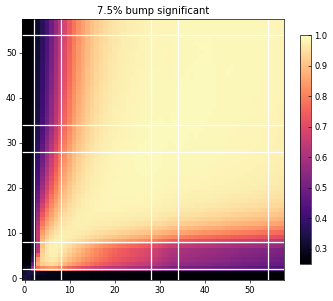

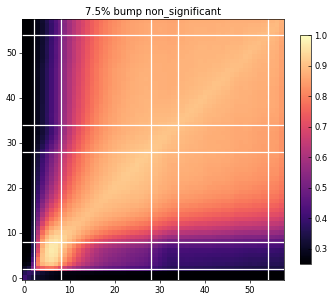

In [217]:
plt.style.use('default')

model_map = {'7.5% bump ': 'bump0.075_480Nrec_'}

for model_ in ['7.5% bump ']:
    for model_pseudo_population in model_pseudo_populations['epoch'].keys():
#         title = model_+model_pseudo_population
        title = model_+model_pseudo_population#+'pca-averaged-delays'
        title = model_+model_pseudo_population#+'pca-stiched-delays-1000'

        plot_cross_temporal_decoding(np.mean(model_decoding_matrices_lda[model_map[model_]+model_pseudo_population+'tau200_rec-noise0.08'], axis=0),
                                     title,
                                     xylines=time_points,
                                     min_val=0.25, max_val=1,
                                     cmap_name='magma',
#                                      save=True,
#                                      size=(12,12))
                                     size=(6,6))

In [ ]:
# with open('saved_results/'+'0.075_model_cross_temporal_decoding-DLPFC-models-PCA-stiched-delays-1000-balanced-36.pkl', 'wb') as f:
#     pickle.dump(model_decoding_matrices_lda, f)

# Model data stability

In [14]:
plt.style.use('default')
from analysis_utils import get_code_stability, get_code_stability_off_diagonal, get_information_quantity

In [15]:
model_code_stabilities = defaultdict(list)
model_information_quantity = defaultdict(list)
model_information_quantity2 = defaultdict(list)
model_stability_generalization = defaultdict(list)

model_rectangular_accuracy = defaultdict(list)

for key in model_decoding_matrices_lda.keys():
    print(key)
    for matrix in model_decoding_matrices_lda[key]:
        # delay1 code stability
        model_code_stabilities[key+'_delay1_full'].append(get_code_stability(matrix[8:28,8:28]))
        model_code_stabilities[key+'_delay1'].append(get_code_stability(matrix[18:28,18:28]))
        model_information_quantity[key+'_delay1'].append(get_information_quantity(matrix[18:28, 18:28]))
            
        # delay2 code stability
        model_code_stabilities[key+'_delay2_full'].append(get_code_stability(matrix[34:54,34:54]))
        model_code_stabilities[key+'_delay2'].append(get_code_stability(matrix[44:54,44:54]))
        model_information_quantity[key+'_delay2'].append(get_information_quantity(matrix[44:54, 44:54]))

        model_information_quantity[key+'_all'].append(get_information_quantity(matrix[np.ix_(np.concatenate([np.arange(18,28), np.arange(44,54)]),
                                                                                             np.concatenate([np.arange(18,28), np.arange(44,54)]))]))

        # get information quantity and code stability of bottom right part of the cross temporal decoding plot
        # (Trained in D1 and tested in D2)
        # Later will divide these with the respective metrics in D1. (Trained in D1 and tested in D1)
        model_information_quantity2[key].append(get_information_quantity(matrix[18:28, 44:54]))
        model_stability_generalization[key].append(get_code_stability(matrix[18:28, 44:54]))
        
        # whole code stabilities 
        model_code_stabilities[key+'_all_diagonal'].append(get_code_stability(matrix[8:54,8:54]))
        model_code_stabilities[key+'_all_off-diagonal'].append(get_code_stability_off_diagonal(matrix[8:54,8:54]))
        
        # get information quantity of first part of delay1
        # get the rectangular of first part of delay1 till the end of the trial for testing and training
        model_information_quantity[key+'_delay1_part1'].append(get_information_quantity(matrix[np.ix_(np.arange(8,18), np.arange(8,18))]))
        model_rectangular_accuracy[key+'_delay1_part1_upper_rect'].append(matrix[np.ix_(np.arange(18,58), np.arange(8,18))])
        upper_trip = np.tril(matrix[np.ix_(np.arange(8,18), np.arange(8,18))], k=-1)
        model_rectangular_accuracy[key+'_delay1_part1_lower_rect'].append(matrix[np.ix_(np.arange(8,18), np.arange(18,58))])
        lower_trip = np.triu(matrix[np.ix_(np.arange(8,18), np.arange(8,18))], k=1)
        model_rectangular_accuracy[key+'_delay1_tri_upper'].append(upper_trip[np.where(upper_trip)])
        model_rectangular_accuracy[key+'_delay1_tri_lower'].append(lower_trip[np.where(lower_trip)])
        
        model_rectangular_accuracy[key+'_delay1_part1'].append([np.mean(matrix[np.ix_(np.arange(18,58), np.arange(8,18))]),
                                                                np.mean(matrix[np.ix_(np.arange(8,18), np.arange(18,58))])])#,
#                                                                         np.mean(upper_trip[np.where(upper_trip)]),
#                                                                         np.mean(lower_trip[np.where(lower_trip)])])

        # get full diagonal
        model_information_quantity[key+'_full_diagonal'].append(get_information_quantity(matrix[np.ix_(np.arange(2,58), np.arange(2,58))]))

bump0.075_480Nrec_significanttau200_rec-noise0.08
bump0.075_480Nrec_non_significanttau200_rec-noise0.08
bump0.075_480Nrec_non-significanttau200_rec-noise0.08


# Save Stability Figures

In [16]:
plt.style.use('default')

plt.style.use('bmh')

<ipython-input-372-76b3cf58fb4d>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


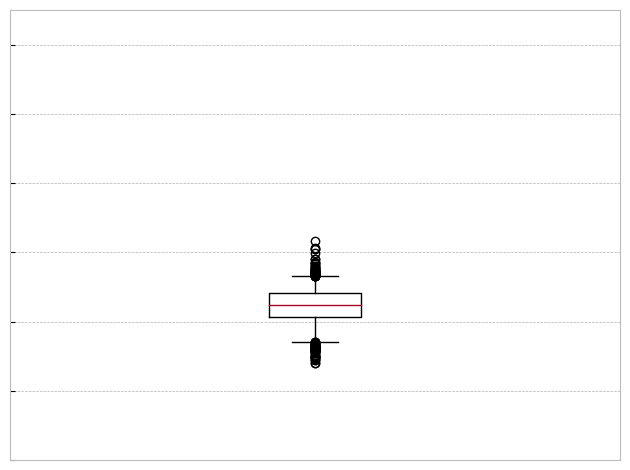

In [372]:
ranges={}
for region in ['7.5% bump ']:
    x_space=0
#     for key in ['significant','non_significant']:#model_information_quantity.keys():
#             x_space+=1
    plt.boxplot(np.array(model_information_quantity[model_map[region]+'non_significant'+'tau200_rec-noise0.08_full_diagonal'])/\
                np.array(model_information_quantity[model_map[region]+'significant'+'tau200_rec-noise0.08_full_diagonal']),
                whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, ['Significant', 'Non-Significant'], fontsize=10)
#     plt.ylabel('Full Information Quantity Non-Significant/Significant')
#     plt.title(region)

#     plt.xticks(np.arange(x_space)+1, [])
    plt.ylim([0.7, 1.35])
    plt.yticks(np.arange(0.7,1.35,0.1),[])

    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

#     plt.savefig('eps_images-new/'+region+'_D2-D1-info-quantity-boxplot.pdf',format='pdf')
#     plt.savefig('eps_images-new/'+region+'_D2-D1-code-stability-boxplot-averaged.pdf',format='pdf')
#     plt.savefig('eps_images-new/'+region+'_full-diagonal-boxplot-averaged.pdf',format='pdf')
    plt.savefig('eps_images-new/'+region+'_full-diagonal-non-significant-divided-by-significant.pdf',format='pdf')


    plt.show()

In [414]:
print("Full Information Quantity ")
full_information =  np.array(model_information_quantity['bump0.075_480Nrec_non_significanttau200_rec-noise0.08_full_diagonal'])/\
                    np.array(model_information_quantity['bump0.075_480Nrec_significanttau200_rec-noise0.08_full_diagonal'])
print('7.5% non-sign/sign:', stats.stats.ttest_ind(full_information, np.ones_like(full_information),
                                                  trim=0.49), '\n')

Full Information Quantity 
7.5% non-sign/sign: Ttest_indResult(statistic=-84.28148367235833, pvalue=8.022926189784354e-45) 



bump0.075_480Nrec_significanttau200_rec-noise0.08_delay1_part1
bump0.075_480Nrec_non_significanttau200_rec-noise0.08_delay1_part1


<ipython-input-356-5bd5e8af9465>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


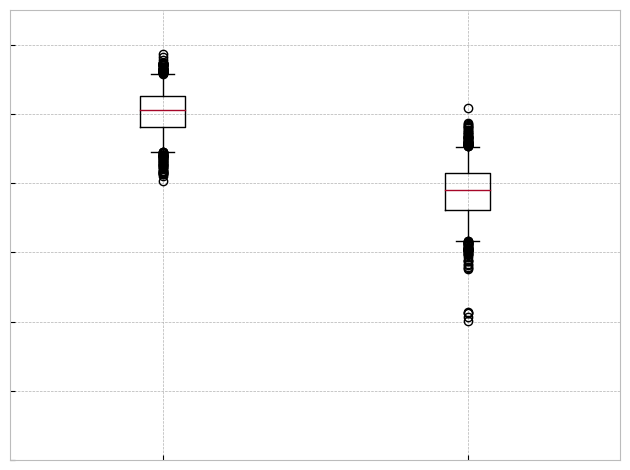

In [356]:
ranges={}
for region in [ '7.5% bump ']:
    x_space=0
    for key in ['significant','non_significant']:#model_information_quantity.keys():
            x_space+=1
            print(model_map[region]+key+'tau200_rec-noise0.08_delay1_part1')
            info_comparison =  np.mean(model_rectangular_accuracy[model_map[region]+key+'tau200_rec-noise0.08_delay1_part1'],axis=1)/\
                              np.array(model_information_quantity[model_map[region]+key+'tau200_rec-noise0.08_delay1_part1'])
#             np.mean(model_rectangular_accuracy[region+key+'_delay1_part1'], axis=1)/\
#                               np.array(information_quantity[region+key+'_delay1_part1'])
            plt.boxplot(info_comparison, whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, ['Significant', 'Non-Significant'], fontsize=10)
#     plt.ylabel('Code Rectangular Stability')
#     plt.title(region)

    plt.xticks(np.arange(x_space)+1, [])
    plt.ylim([0.4, 1.05])
    plt.yticks(np.arange(0.4,1.05,0.1),[])

    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

#     plt.savefig('eps_images-new/'+region+'_D2-D1-info-quantity-boxplot.pdf',format='pdf')
#     plt.savefig('eps_images-new/'+region+'_D2-D1-code-stability-boxplot-averaged.pdf',format='pdf')
    plt.savefig('eps_images-new/'+region+'_code-rectangular-stability-boxplot-averaged.pdf',format='pdf')

    plt.show()